## **Importing algorithms**


In [1]:
import sys
from pathlib import Path
import time
import math

sys.path.append(str(Path("/Users/nada/PycharmProjects/Mars_rover_path_finding /Mars_rover_path_finding/src").resolve()))

In [2]:
from algorithms.bfs import bfs
from algorithms.dfs import dfs
from algorithms.ucs import ucs
from algorithms.ids import ids
from algorithms.A_star import A_star
from algorithms.hill_climbing import hill_climbing

## **Initializing the Maps (Elevation and Terrain)**

In [3]:
import numpy as np
np.random.seed(42)

# Simulated grid dimensions
N, M = 50, 50
cliff_prob = 0.1

elevation = np.random.randint(0, 15, size=(N, M))
terrain = np.random.choice([0, 1, 2, 3], size=(N, M), p=[0.5, 0.25, 0.15, cliff_prob])

# To make sure start and goal are valid
start = (0, 0)
goal = (37, 26)
terrain[start] = 0
terrain[goal] = 0

terrain_cost = {0: 4, 1: 8, 2: 13, 3: np.inf}

In [4]:
def move_cost(current, neighbor):
    x1, y1 = current
    x2, y2 = neighbor

    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    # Diagonal (octile) distance
    D = 1
    D2 = math.sqrt(2)
    distance = D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)

    elevation_change = abs(elevation[x2, y2] - elevation[x1, y1])
    slope = elevation_change / distance

    t_factor = terrain_cost[terrain[x2, y2]]

    if t_factor == np.inf:
        return np.inf
    return distance * t_factor * (1 + slope)

print("Cost from start to (0,1):", move_cost(start, (0,1)))

print("Elevation Map:\n", elevation)
print("Terrain Map:\n", terrain)

Cost from start to (0,1): 16.0
Elevation Map:
 [[ 6  3 12 ... 14 13  2]
 [11  6  3 ...  1  9 11]
 [ 1  9 13 ... 10  4  9]
 ...
 [ 4  7 11 ...  8  7 10]
 [ 5  2  7 ...  2 10  5]
 [ 8  5  8 ...  3 12  7]]
Terrain Map:
 [[0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 1]
 [0 0 3 ... 2 3 0]
 ...
 [1 1 0 ... 3 0 0]
 [0 0 1 ... 0 1 0]
 [2 1 1 ... 1 0 2]]


In [5]:
import networkx as nx
G = nx.DiGraph()

directions = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]

for x in range(N):
    for y in range(M):
        if terrain_cost[terrain[x,y]] == np.inf:
            continue
        for dx, dy in directions:
            nx_, ny_ = x + dx, y + dy
            if 0 <= nx_ < N and 0 <= ny_ < M:
                cost = move_cost((x,y), (nx_,ny_))
                if cost < np.inf:
                    G.add_edge((x,y), (nx_,ny_), weight=cost)


print(G[(0,0)])

{(0, 1): {'weight': 16.0}, (1, 1): {'weight': 11.313708498984761}, (1, 0): {'weight': 48.0}}


In [6]:
all_costs = [v for v in terrain_cost.values() if v < np.inf]
average_terrain_cost = np.mean(all_costs)

## **High-Fidelity Realistic Visualization**

In [7]:
import matplotlib as mpl
mpl.rcParams['animation.writer'] = 'ffmpeg'
# You can keep the bitrate setting you already added
mpl.rcParams['animation.bitrate'] = 1200

In [8]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator  # Added for accurate surface tracking
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import animation
from matplotlib.patches import Patch
import numpy as np
from IPython.display import HTML

# Make inline animation embeds smaller/allowed
mpl.rcParams['animation.embed_limit'] = 100  # MB
mpl.rcParams['animation.bitrate'] = 1200     # lower bitrate → smaller video


def visualize_realistic_mission(elevation_map, terrain_map, path_coords, goal_coords,
                                cell_size: float = 3.5,
                                z_exaggeration: float = 3.0):
    rows, cols = elevation_map.shape

    # 1. Smooth the Elevation Map
    Z_smooth = gaussian_filter(elevation_map.astype(float), sigma=0.8)

    # --- NEW: Create a surface interpolator ---
    # This allows us to find the exact height of the ground at any point (x, y)
    # ensuring the rover sticks to the curve instead of cutting through it.
    y_grid = np.arange(rows)
    x_grid = np.arange(cols)
    terrain_interp = RegularGridInterpolator((y_grid, x_grid), Z_smooth)

    # 2. Interpolate Path for Smooth Continuous Movement
    steps_per_move = 4 # Increased slightly for smoother visuals
    smooth_path_x = []
    smooth_path_y = []
    smooth_path_z = []

    for i in range(len(path_coords) - 1):
        p1 = path_coords[i]
        p2 = path_coords[i + 1]

        # Interpolate X and Y
        xs = np.linspace(p1[1], p2[1], steps_per_move, endpoint=False)
        ys = np.linspace(p1[0], p2[0], steps_per_move, endpoint=False)

        # --- FIX: Calculate Z using the interpolator ---
        # Instead of a straight line, we ask "what is the surface height here?"
        # The interpolator expects (y, x) order
        query_points = np.column_stack((ys, xs))
        zs = terrain_interp(query_points)

        smooth_path_x.extend(xs)
        smooth_path_y.extend(ys)
        smooth_path_z.extend(zs)

    # Append the final destination
    last = path_coords[-1]
    smooth_path_x.append(last[1])
    smooth_path_y.append(last[0])
    # Get exact height for the last point
    last_z = terrain_interp([[last[0], last[1]]])[0]
    smooth_path_z.append(last_z)


    # 3. Setup the Scene
    fig = plt.figure(figsize=(14, 10), dpi=80)
    ax = fig.add_subplot(111, projection='3d')

    # Scale the grid coordinates
    X, Y = np.meshgrid(np.arange(cols) * cell_size, np.arange(rows) * cell_size)

    # 4. Realistic Coloring
    real_colors = ['#EEE8AA', '#F4A460', '#8B4513', '#2F4F4F']
    cmap = colors.ListedColormap(real_colors)
    norm = colors.BoundaryNorm([0, 1, 2, 3, 4], cmap.N)
    face_colors = cmap(norm(terrain_map))

    ax.plot_surface(X, Y, Z_smooth * z_exaggeration, facecolors=face_colors,
                    rstride=1, cstride=1, shade=True, alpha=0.95,
                    linewidth=0, antialiased=True)

    # Legend
    terrain_labels = ['Sand', 'Rough', 'Rocky', 'Cliff']
    legend_handles = [
        Patch(facecolor=real_colors[i], edgecolor='black', label=terrain_labels[i])
        for i in range(4)
    ]
    ax.legend(handles=legend_handles, title='Terrain', loc='lower left',
              bbox_to_anchor=(1.02, 0.0), frameon=True)

    # Plot the path trail
    path_x_grid = [p[1] * cell_size for p in path_coords]
    path_y_grid = [p[0] * cell_size for p in path_coords]
    # We re-calculate path Zs using interpolator for the static line too, so it hugs terrain
    path_z_raw = terrain_interp(np.array(path_coords))
    path_z_grid = path_z_raw * z_exaggeration + 0.2 # Small lift to prevent z-fighting

    ax.plot(path_x_grid, path_y_grid, path_z_grid, color='white', linestyle=':',
            linewidth=2, alpha=0.7, label='Planned Route')

    # --- NEW: GOAL MARKER ---
    # Simple tiny text box at the goal
    g_row, g_col = goal_coords

    goal_x = g_col * cell_size
    goal_y = g_row * cell_size
    goal_z = terrain_interp([[g_row, g_col]])[0] * z_exaggeration + 2.5 # Float it a bit higher

    ax.text(goal_x, goal_y, goal_z, "GOAL", color='black', fontsize=10, weight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8),
            zorder=10)


    # Create the Rover
    halo, = ax.plot([], [], [], marker='o', markersize=24,
                    color='white', alpha=0.6, markeredgecolor='none', zorder=2)
    rover, = ax.plot([], [], [], marker='o', markersize=18, color='#ff1744',
                     markeredgecolor='black', markeredgewidth=3, label='Rover', zorder=3)

    # 5. Styling and View
    ax.set_title('High-Fidelity Mars Mission Simulation', fontsize=16, color='black')
    ax.set_axis_off()
    ax.view_init(elev=55, azim=-60)

    # Aspect Ratio Logic
    try:
        zmin = float(np.min(Z_smooth)) * z_exaggeration
        zmax = float(np.max(Z_smooth)) * z_exaggeration
        ax.set_box_aspect((cols * cell_size, rows * cell_size, max(1e-6, zmax - zmin)))
        ax.set_zlim(zmin, zmax)
    except Exception:
        ax.set_zlim(0, 15)

    def update(frame):
        cx = smooth_path_x[frame] * cell_size
        cy = smooth_path_y[frame] * cell_size
        # Apply exaggeration to the accurate surface height + offset
        cz = (smooth_path_z[frame] * z_exaggeration) + 0.8

        halo.set_data([cx], [cy])
        halo.set_3d_properties([cz])
        rover.set_data([cx], [cy])
        rover.set_3d_properties([cz])
        return halo, rover

    frames = range(0, len(smooth_path_x))
    anim = animation.FuncAnimation(fig, update, frames=frames, interval=30, blit=False)

    return anim

## **BFS**

In [9]:
start_t = time.perf_counter()
bfs_path, bfs_nodes = bfs(G, start, goal)
bfs_elapsed = time.perf_counter() - start_t
print(f"BFS: time={bfs_elapsed:.6f}s, explored_nodes={bfs_nodes} path_len={len(bfs_path) if bfs_path else None}")

BFS: time=0.001268s, explored_nodes=1280 path_len=38


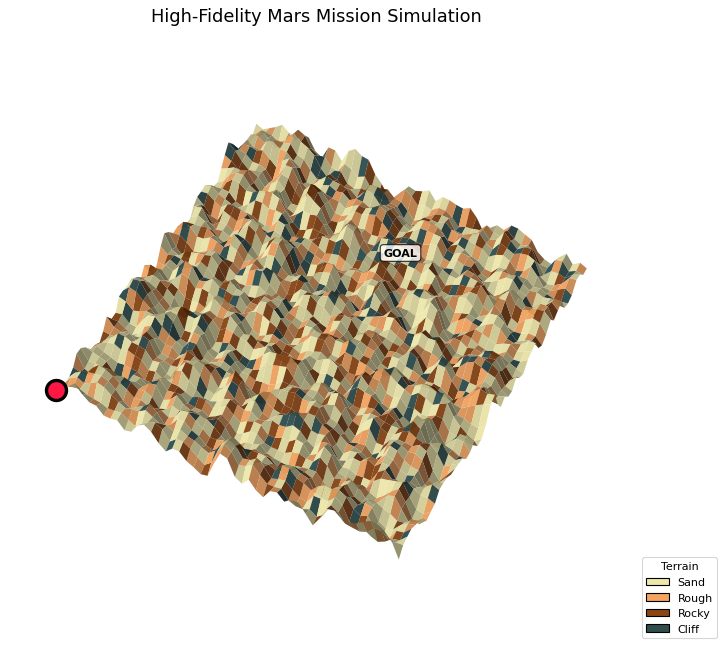

In [10]:
anim_real = visualize_realistic_mission(elevation, terrain, bfs_path, goal)
anim_real.save('bfs_rover.mp4', writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video('bfs_rover.mp4', embed=False)

## **DFS**

In [11]:
start_t = time.perf_counter()
dfs_path, dfs_depth, dfs_nodes = dfs(G, start, goal)
dfs_elapsed = time.perf_counter() - start_t
print(f"DFS: depth={dfs_depth}, explored_nodes={dfs_nodes} time={dfs_elapsed:.6f}s, path_len={len(dfs_path) if dfs_path else None}")

DFS: depth=119, explored_nodes=2114 time=0.006274s, path_len=120


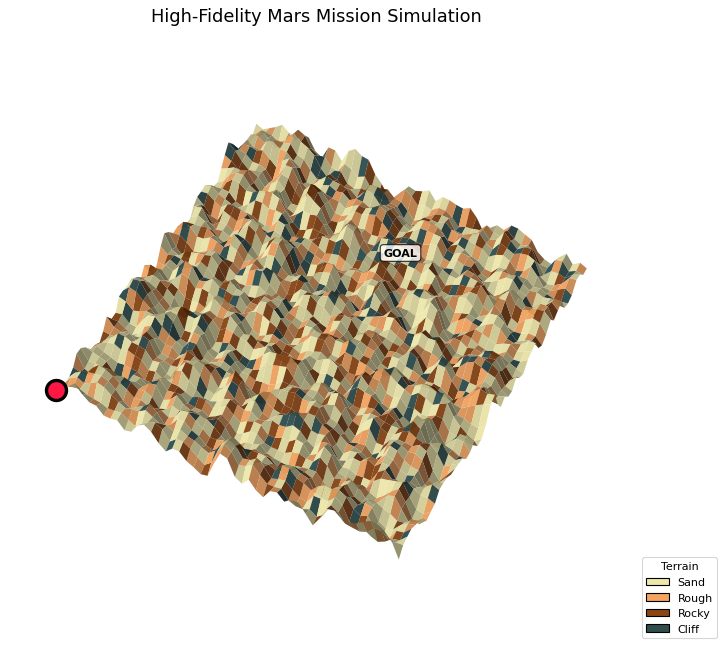

In [12]:
anim_real = visualize_realistic_mission(elevation, terrain, dfs_path, goal)
anim_real.save('dfs_rover.mp4', writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video('dfs_rover.mp4', embed=False)

## **IDS**

In [13]:
max_depth = 100
start_t = time.perf_counter()
ids_path, ids_depth, ids_nodes = ids(G, start, goal, max_depth)
ids_elapsed = time.perf_counter() - start_t
print(f"IDS: depth={ids_depth}, explored_nodes={ids_nodes} time={ids_elapsed:.6f} s, path_len={len(ids_path) if ids_path else None}")

IDS: depth=37, explored_nodes=929683 time=0.351721 s, path_len=42


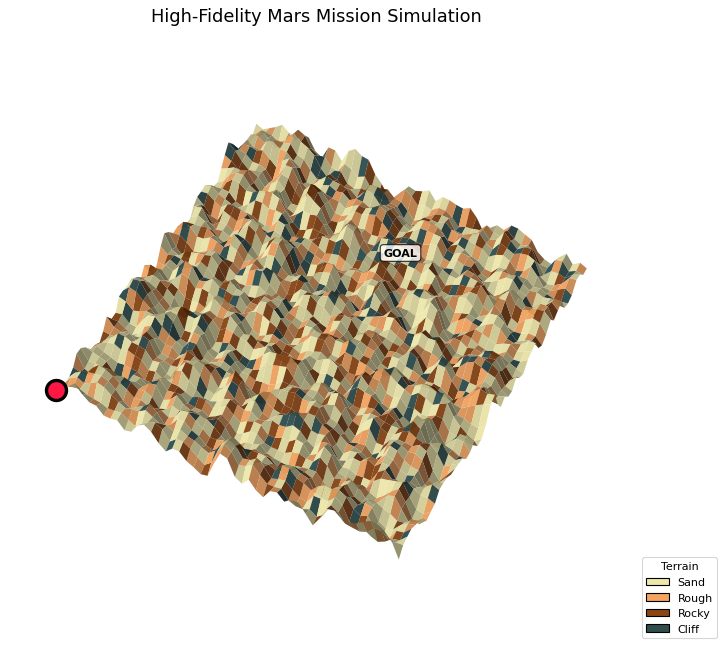

In [14]:
anim_real = visualize_realistic_mission(elevation, terrain, ids_path, goal)
anim_real.save(f"ids_path_max_{max_depth}_rover.mp4", writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video(f"ids_path_max_{max_depth}_rover.mp4", embed=False)

## **DFS vs IDS depth, time, path length**

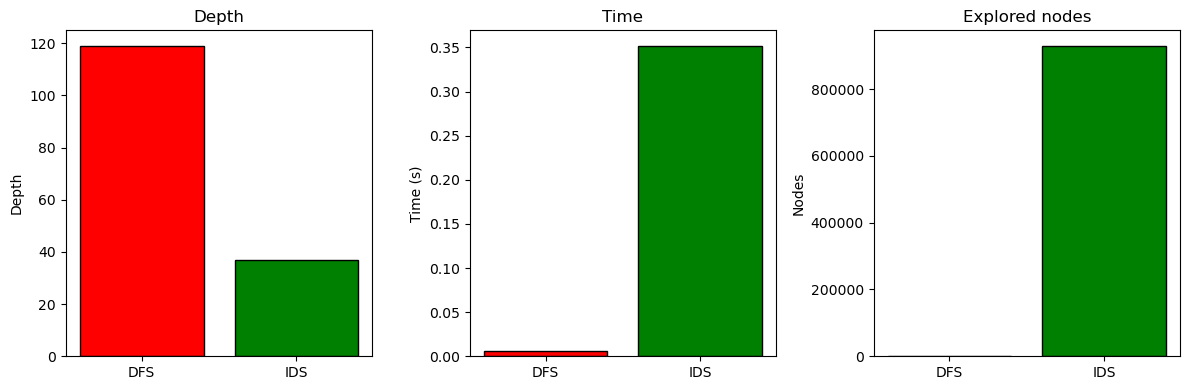

In [16]:
import matplotlib.pyplot as plt

depth_vals = [dfs_depth, ids_depth]
time_vals = [dfs_elapsed, ids_elapsed]
nodes_explored_vals = [dfs_nodes, ids_nodes]

labels = ['DFS', 'IDS']
bar_colors = ['red', 'green']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].bar(labels, depth_vals, color=bar_colors, edgecolor='black')
axs[0].set_title('Depth')
axs[0].set_ylabel('Depth')

axs[1].bar(labels, time_vals, color=bar_colors, edgecolor='black')
axs[1].set_title('Time')
axs[1].set_ylabel('Time (s)')

axs[2].bar(labels, nodes_explored_vals, color=bar_colors, edgecolor='black')
axs[2].set_title('Explored nodes')
axs[2].set_ylabel('Nodes')

plt.tight_layout()
plt.show()


## **UCS**

In [7]:
start_t = time.perf_counter()
ucs_path, ucs_cost, ucs_nodes, ucs_costs, ucs_visited_nodes = ucs(G, start, goal)
ucs_elapsed = time.perf_counter() - start_t
print(f"UCS: cost={ucs_cost}, time={ucs_elapsed:.6f} s, nodes={ucs_nodes} path_len={len(ucs_path) if ucs_path else None}")

UCS: cost=645.3036072312179, time=0.020650 s, nodes=1887 path_len=44


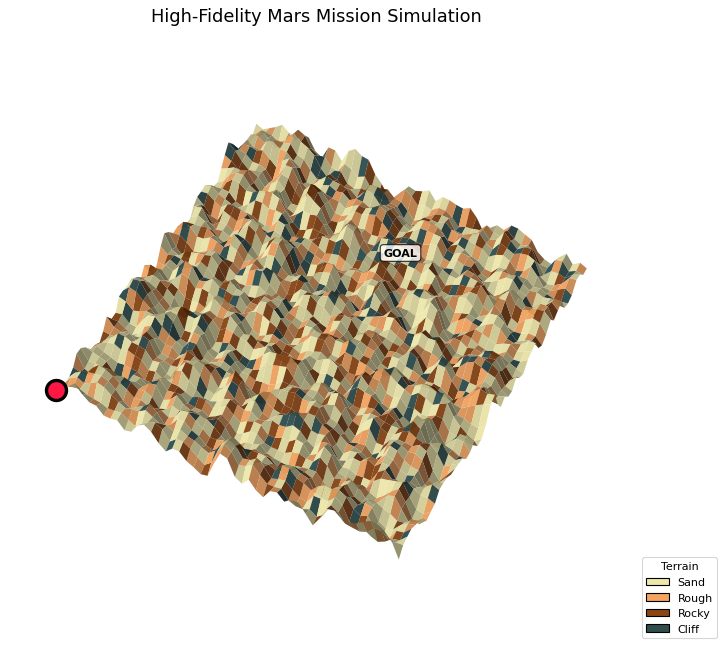

In [18]:
anim_real = visualize_realistic_mission(elevation, terrain, ucs_path, goal)
anim_real.save(f"ucs_rover.mp4", writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video(f"ucs_rover.mp4", embed=False)

In [19]:
print(ucs_costs)

{(0, 0): 0, (0, 1): 16.0, (1, 1): 11.313708498984761, (1, 0): 48.0, (0, 2): 40.97056274847714, (1, 2): 27.31370849898476, (2, 1): 27.31370849898476, (2, 0): 36.97056274847714, (0, 3): 52.97056274847714, (1, 3): 51.31370849898476, (2, 3): 38.62741699796952, (3, 2): 36.970562748477136, (3, 1): 40.31370849898476, (3, 3): 88.97056274847714, (4, 3): 80.2842712474619, (4, 2): 60.970562748477136, (1, 4): 57.94112549695428, (2, 4): 76.97056274847714, (3, 4): 56.2842712474619, (4, 0): 85.94112549695429, (0, 4): 64.97056274847714, (2, 5): 92.97056274847714, (3, 5): 68.2842712474619, (4, 5): 92.2842712474619, (4, 4): 92.2842712474619, (0, 5): 96.97056274847714, (1, 5): 69.94112549695427, (5, 3): 104.2842712474619, (5, 2): 88.97056274847714, (5, 1): 74.62741699796952, (2, 6): 96.97056274847714, (3, 6): 84.2842712474619, (4, 6): 89.94112549695429, (0, 6): 107.59797974644665, (1, 6): 81.94112549695427, (6, 2): 120.2842712474619, (6, 1): 94.62741699796952, (6, 0): 104.2842712474619, (5, 0): 114.62741

## **A_star**

In [8]:
start_t = time.perf_counter()
Astar_path, Astar_cost, h_values, Astar_nodes, Astar_gcosts, Astar_visited_nodes = A_star(G, start, goal, average_terrain_cost)
Astar_elapsed = time.perf_counter() - start_t
print(f"Astar: cost={Astar_cost}, time={Astar_elapsed:.6f} s, nodes={Astar_nodes}, path_len={len(Astar_path) if Astar_path else None}")

Astar: cost=648.6173157302028, time=0.009765 s, nodes=1073, path_len=44


In [21]:
print(Astar_gcosts)

{(0, 0): 0, (0, 1): 16.0, (1, 1): 11.313708498984761, (1, 0): 48.0, (0, 2): 40.97056274847714, (1, 2): 27.31370849898476, (2, 1): 27.31370849898476, (2, 0): 36.97056274847714, (3, 2): 36.970562748477136, (3, 1): 40.31370849898476, (2, 3): 38.62741699796952, (3, 3): 88.97056274847714, (4, 3): 80.2842712474619, (4, 2): 60.970562748477136, (4, 0): 85.94112549695429, (0, 3): 52.97056274847714, (1, 3): 51.31370849898476, (1, 4): 57.94112549695428, (2, 4): 76.97056274847714, (3, 4): 56.2842712474619, (2, 5): 92.97056274847714, (3, 5): 68.2842712474619, (4, 5): 92.2842712474619, (4, 4): 92.2842712474619, (5, 3): 104.2842712474619, (5, 2): 88.97056274847714, (5, 1): 74.62741699796952, (2, 6): 96.97056274847714, (3, 6): 84.2842712474619, (4, 6): 89.94112549695429, (6, 2): 120.2842712474619, (6, 1): 94.62741699796952, (6, 0): 104.2842712474619, (5, 0): 114.62741699796952, (0, 4): 64.97056274847714, (0, 5): 96.97056274847714, (1, 5): 69.94112549695427, (3, 7): 99.59797974644667, (5, 7): 103.59797

## **Analysis of heuristic effectiveness**


In [22]:
import matplotlib.pyplot as plt

def visualize_heuristic(h_values, grid_shape):
    vis_grid = np.full(grid_shape, np.nan)

    for (r, c), val in h_values.items():
        vis_grid[r, c] = val

    plt.figure(figsize=(8, 6))
    plt.imshow(vis_grid, cmap='viridis')
    plt.colorbar(label='Heuristic Cost (h)')
    plt.title("Heuristic Values Explored by A*")
    plt.show()

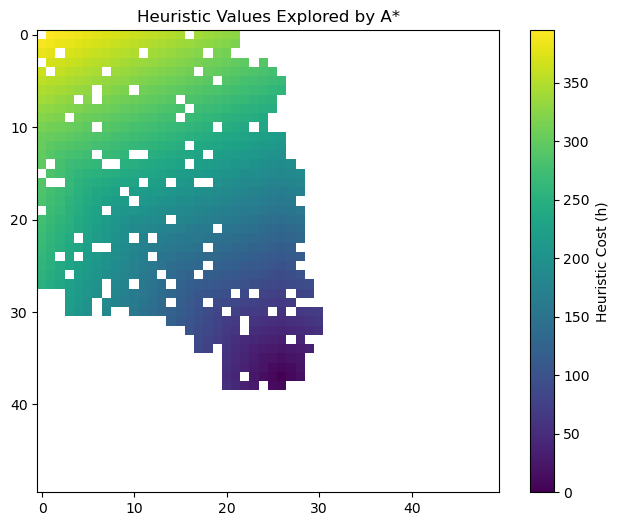

In [23]:
visualize_heuristic(h_values, (50, 50))

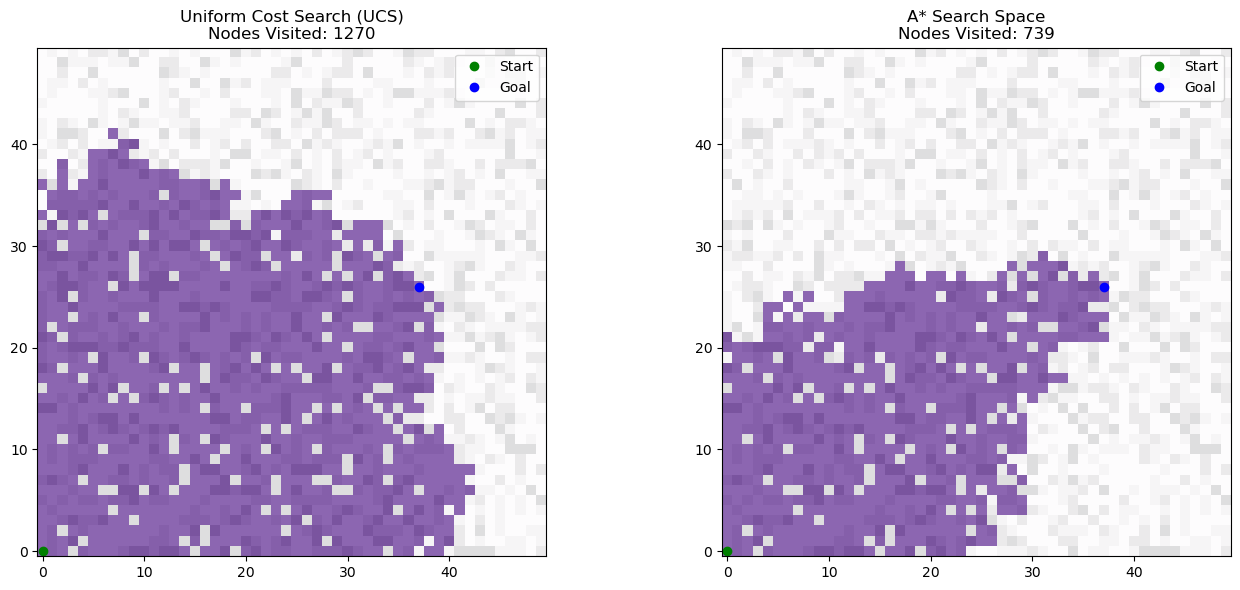

In [11]:
import matplotlib.pyplot as plt

def plot_search_space(visited_nodes, title, ax):
    display_grid = np.zeros((N, M))
    for (x, y) in visited_nodes:
        display_grid[x, y] = 1

    # Show terrain as the background
    ax.imshow(terrain.T, cmap='Greys', alpha=0.3, origin='lower')

    # Overlay visited nodes
    ax.imshow(display_grid.T, cmap='Purples', alpha=0.6, origin='lower')

    # Plot Start and Goal
    ax.plot(start[0], start[1], 'go', label='Start')
    ax.plot(goal[0], goal[1], 'bo', label='Goal')
    ax.set_title(f"{title}\nNodes Visited: {len(visited_nodes)}")
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

plot_search_space(ucs_visited_nodes, "Uniform Cost Search (UCS)", ax1)
plot_search_space(Astar_visited_nodes, "A* Search Space", ax2)

plt.tight_layout()
plt.show()

In [24]:
print(h_values)

{(0, 1): 394.6278254943948, (1, 1): 386.2944921610615, (1, 0): 389.7462718475039, (0, 2): 391.1760458079524, (1, 2): 382.8427124746191, (2, 1): 377.9611588277282, (2, 0): 381.4129385141706, (3, 2): 366.1760458079524, (3, 1): 369.6278254943948, (2, 3): 371.0575994548432, (3, 3): 362.7242661215099, (4, 3): 354.3909327881766, (4, 2): 357.8427124746191, (4, 0): 364.7462718475039, (0, 3): 387.7242661215099, (1, 3): 379.3909327881766, (1, 4): 375.9391531017341, (2, 4): 367.6058197684008, (3, 4): 359.2724864350675, (2, 5): 364.1540400819583, (3, 5): 355.82070674862496, (4, 5): 347.48737341529164, (4, 4): 350.9391531017341, (5, 3): 346.0575994548432, (5, 2): 349.50937914128576, (5, 1): 352.9611588277282, (2, 6): 360.70226039551585, (3, 6): 352.36892706218254, (4, 6): 344.0355937288492, (6, 2): 341.1760458079524, (6, 1): 344.6278254943948, (6, 0): 348.0796051808373, (5, 0): 356.4129385141706, (0, 4): 384.2724864350675, (0, 5): 380.82070674862496, (1, 5): 372.48737341529164, (3, 7): 348.91714737

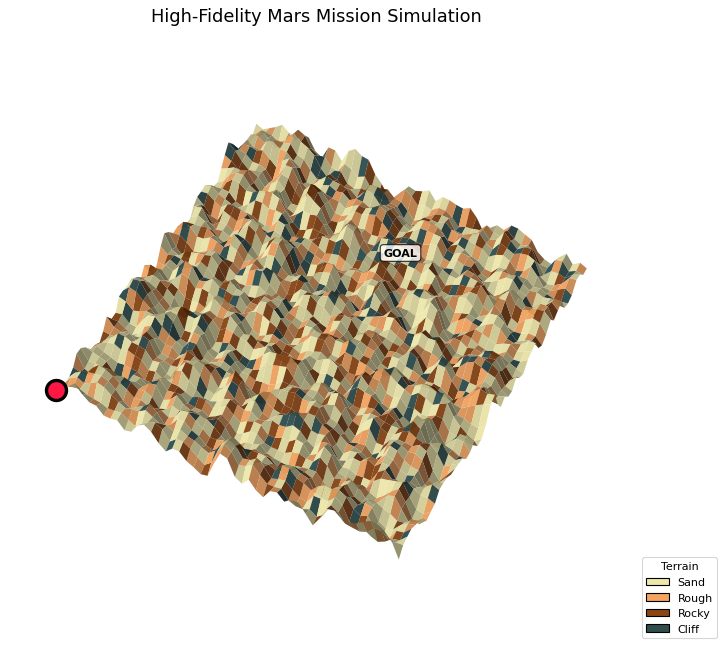

In [25]:
anim_real = visualize_realistic_mission(elevation, terrain, Astar_path, goal)
anim_real.save(f"Astar_rover.mp4", writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video(f"Astar_rover.mp4", embed=False)

## **Hill Climbing**

In [26]:
start_t = time.perf_counter()
found, hill_climbing_path, hill_climbing_explored_nodes = hill_climbing(G, start, goal, average_terrain_cost)
hill_climbing_elapsed = time.perf_counter() - start_t
print(f"Hill Climbing: found= {found} time={hill_climbing_elapsed:.6f} s, explored_nodes={hill_climbing_explored_nodes}")

Hill Climbing: found= True time=0.000295 s, explored_nodes=37


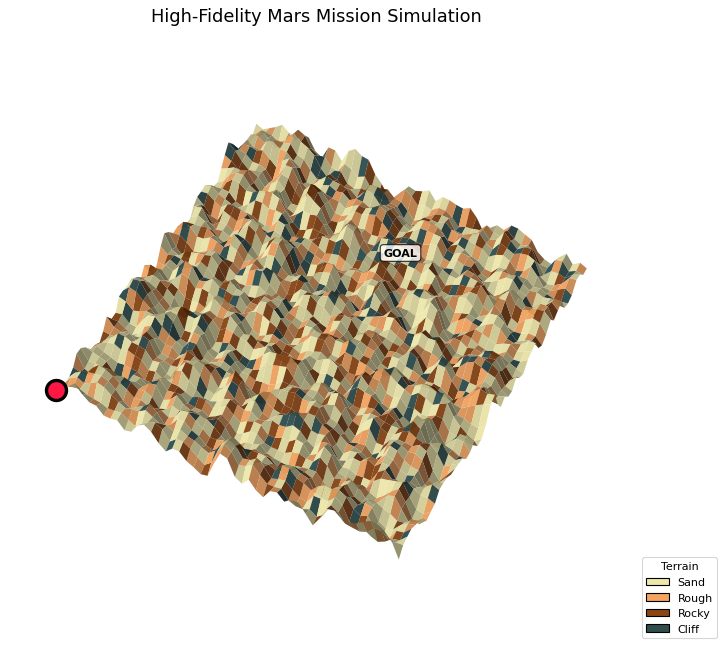

In [27]:
anim_real = visualize_realistic_mission(elevation, terrain, hill_climbing_path, goal)
anim_real.save(f"hill_climbing_rover.mp4", writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video(f"hill_climbing_rover.mp4", embed=False)

In [28]:
start_t = time.perf_counter()
goal2 = (49, 49)
found2, hill_climbing_path2, hill_climbing_explored_nodes2 = hill_climbing(G, start, goal2, average_terrain_cost)
hill_climbing_elapsed2 = time.perf_counter() - start_t
print(f"Hill Climbing: found= {found2} time={hill_climbing_elapsed2:.6f} s, explored_nodes={hill_climbing_explored_nodes2}")

Hill Climbing: found= False time=0.000855 s, explored_nodes=49


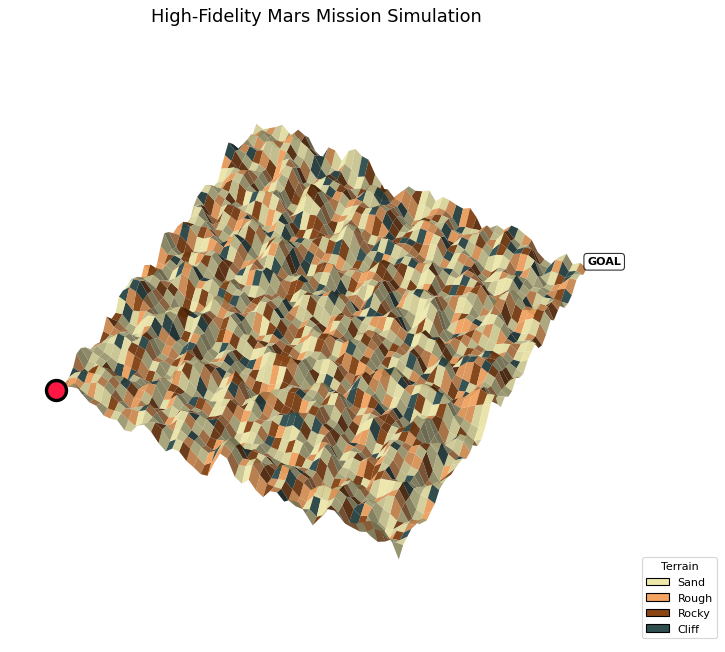

In [29]:
anim_real = visualize_realistic_mission(elevation, terrain, hill_climbing_path2, goal2)
anim_real.save(f"hill_climbing_rover2.mp4", writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video(f"hill_climbing_rover2.mp4", embed=False)

In [31]:
import pandas as pd

results = pd.DataFrame({
    "Algorithm": ["BFS", "DFS", "IDS", "UCS", "A*", "Hill Climbing"],
    "Path Length": [len(bfs_path), len(dfs_path), len(ids_path), len(ucs_path), len(Astar_path), len(hill_climbing_path)],
    "Nodes Explored": [bfs_nodes, dfs_nodes, ids_nodes, ucs_nodes, Astar_nodes, hill_climbing_explored_nodes],
    "Time (ms)": [bfs_elapsed, dfs_elapsed, ids_elapsed, ucs_elapsed, Astar_elapsed, hill_climbing_elapsed]
})


In [33]:
results.to_csv("/Users/nada/PycharmProjects/Mars_rover_path_finding /Mars_rover_path_finding/results/search_algorithm_results.csv", index=False)